In [40]:
import cartopy.crs as ccrs
import dataclasses
import datetime
from functools import cache
import numcodecs as ncd
import numpy as np
import s3fs
import xarray as xr
import pandas as pd

In [41]:
fs = s3fs.S3FileSystem(anon=True)

lat = 42.35843
lng = -71.05977

In [42]:
def fix_accum_var_dims(ds, var):
    # Some varibles like precip have extra time bounds varibles, we drop them here to allow merging with other variables
    
    # Select variable of interest (drops dims that are not linked to current variable)
    ds = ds[[var]]  

    if var in ['air_temperature_at_2_metres',
               'dew_point_temperature_at_2_metres',
               'air_pressure_at_mean_sea_level',
               'northward_wind_at_10_metres',
               'eastward_wind_at_10_metres']:
        
        ds = ds.rename({'time0':'valid_time_end_utc'})
        
    elif var in ['precipitation_amount_1hour_Accumulation',
                 'integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation']:
        
        ds = ds.rename({'time1':'valid_time_end_utc'})
        
    else:
        print("Warning, Haven't seen {var} varible yet! Time renaming might not work.".format(var=var))
        
    return ds

In [43]:
def fetch_data(start_date: datetime.datetime, end_date: datetime.datetime, variables: list):
  file_pattern = 'era5-pds/zarr/{year}/{month:02}/data/{var}.zarr/'
  file_dates = list(pd.date_range(start_date, end_date, freq='MS'))
  l = []
  for var in variables:
    file_names = [file_pattern.format(year=file_date.year, month=file_date.month, var=var) for file_date in file_dates]
    print(file_names)
    s3_files = (s3fs.S3Map(file_name, s3=fs) for file_name in file_names)
    # Look up correct time dimension by variable name
    if var in ['precipitation_amount_1hour_Accumulation']:
      concat_dim='time1'
    else:
      concat_dim='time0'
    # Lazy load
    ds = xr.open_mfdataset(s3_files, engine='zarr', 
                           concat_dim=concat_dim, combine='nested', 
                           coords='minimal', compat='override', parallel=True)
    
    # Fix dimension names
    ds = fix_accum_var_dims(ds, var)
    l.append(ds)

  return xr.merge(l)

['era5-pds/zarr/2022/01/data/snow_density.zarr/', 'era5-pds/zarr/2022/02/data/snow_density.zarr/']
Warning, Haven't seen snow_density varible yet! Time renaming might not work.
<xarray.Dataset>
Dimensions:       (time0: 1416, lat: 721, lon: 1440)
Coordinates:
  * lat           (lat) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon           (lon) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time0         (time0) datetime64[ns] 2022-01-01 ... 2022-02-28T23:00:00
Data variables:
    snow_density  (time0, lat, lon) float32 dask.array<chunksize=(372, 150, 150), meta=np.ndarray>
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    title:        ERA5 forecasts


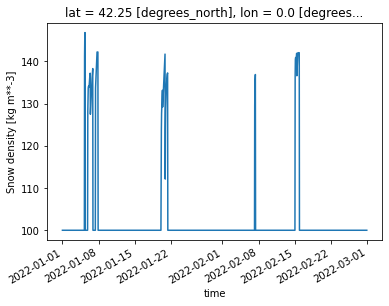

In [44]:
start_date = datetime.datetime(2022, 1, 1)
end_date = datetime.datetime(2022, 2, 1)
data = fetch_data(start_date, end_date, ['snow_density'])
print(data)
data = data.sel(lat=lat, lon=lng, method='nearest')
data['snow_density'].plot()
